In [1]:
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses, layers, models, metrics, Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, metrics
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import torch
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = 'cifar-10-batches-py/test_batch'
    else:
        name = 'cifar-10-batches-py/data_batch_' + str(i + 1)
    files.append(unpickle(name))

In [4]:
rotations_num = 4
augment_num = 10

saved_name = 'selfsupervised'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [5]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [6]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [7]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

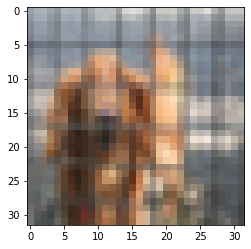

[1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


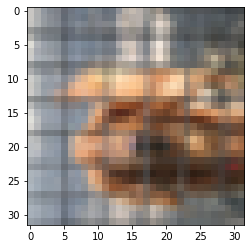

[0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


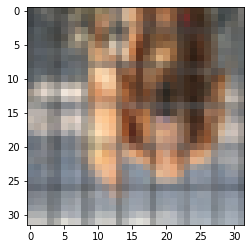

[0. 0. 1. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


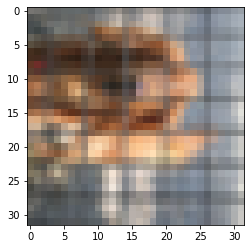

[0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [9]:
#combined_data = preprocess_input(combined_data)

In [10]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
            
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [11]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4, name='out_layer')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(rotations_num, kernel_regularizer=regularizers.l2(l = 0.0001), activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [12]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.get_layer(feature_layer_trained).output
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [13]:
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    
    return lr

In [14]:
def lr_schedule_conv(epoch, lr):
    print(lr)
    if epoch == 80:
        return lr / 5.
    if epoch == 60:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    
    return lr

In [15]:
def lr_schedule_cls(epoch, lr):
    print(lr)
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    if epoch == 10:
        return lr / 5.
    
    return lr

In [16]:
def lr_schedule_linear(epoch, lr):
    print(lr)
    if epoch < supervised_epochs // 2:
        return lr + (0.1 - 0.00001) / supervised_epochs * 2.
    else:
        return max(lr - (0.1 - 0.00001) / supervised_epochs * 2., 0.00001)
    
    return lr

In [17]:
def train_feat():
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name)
    return log

In [18]:
log = train_feat()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Train on 240000 samples
Epoch 1/80
240000/240000 [==============================] - 40s 169us/sample - loss: 2.1408 - accuracy: 0.5871
Epoch 2/80
240000/240000 [==============================] - 37s 153us/sample - loss: 1.5825 - accuracy: 0.6723
Epoch 3/80
240000/240000 [==============================] - 37s 153us/sample - loss: 1.4982 - accuracy: 0.7153
Epoch 4/80
240000/240000 [==============================] - 37s 154us/sample - loss: 1.4170 - accuracy: 0.7436
Epoch 5/80
240000/240000 [==============================] - 37s 154us/sample - loss: 1.3465 - accuracy: 0.7623
Epoch 6/80
240000/240000 [==============================] - 37s 155us/sample - loss: 1.2843 - accuracy: 0.7771
Epoch 7/80
240000/240000 [==============================] - 37s 155us/sample - loss: 1.2277 - accuracy: 0.7907
Epoch 8/80
240000/240000 [==============================] - 37s 155us/sample - loss: 1.1803 - accuracy: 0.8016
Epoch 9/80
240000/240000 [==============================] - 37s 152us/sample - loss: 1.1

240000/240000 [==============================] - 36s 152us/sample - loss: 0.1021 - accuracy: 0.9773
Epoch 75/80
240000/240000 [==============================] - 37s 154us/sample - loss: 0.1011 - accuracy: 0.9777
Epoch 76/80
240000/240000 [==============================] - 37s 153us/sample - loss: 0.1015 - accuracy: 0.9776
Epoch 77/80
240000/240000 [==============================] - 37s 153us/sample - loss: 0.1009 - accuracy: 0.9779
Epoch 78/80
240000/240000 [==============================] - 37s 154us/sample - loss: 0.1002 - accuracy: 0.9776
Epoch 79/80
240000/240000 [==============================] - 37s 153us/sample - loss: 0.1008 - accuracy: 0.9776
Epoch 80/80
240000/240000 [==============================] - 37s 155us/sample - loss: 0.1002 - accuracy: 0.9778
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: selfsupervised/assets


In [19]:
def get_cls_model(name = saved_name, use_features = True, percent = 100):
    if use_features:
        model = tf.keras.models.load_model(name)
    else:
        model = tf.keras.models.load_model('emptyResNet')
        
    if percent >= 50:
        l = model.get_layer(feature_layer).output
    else:
        l = model.get_layer(first_resnet_layer).output
        
    #model = tf.keras.models.load_model(cnn_name)
    #l = model.get_layer(feature_layer_cnn).output
    
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [20]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
            
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [21]:
cls_train_features = train_cls(True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 240us/sample - loss: 4.3538 - accuracy: 0.4132 - val_loss: 3.4000 - val_accuracy: 0.4934
Epoch 2/50
50000/50000 [==============================] - 9s 179us/sample - loss: 3.0372 - accuracy: 0.5451 - val_loss: 3.0208 - val_accuracy: 0.5107
Epoch 3/50
50000/50000 [==============================] - 9s 178us/sample - loss: 2.7176 - accuracy: 0.5967 - val_loss: 2.9609 - val_accuracy: 0.5103
Epoch 4/50
50000/50000 [==============================] - 9s 180us/sample - loss: 2.5486 - accuracy: 0.6303 - val_loss: 2.6063 - val_accuracy: 0.6041
Epoch 5/50
50000/50000 [==============================] - 9s 178us/sample - loss: 2.4448 - accuracy: 0.6555 - val_loss: 2.6550 - val_accuracy: 0.6009
Epoch 6/50
50000/50000 [==============================] - 9s 177us/sample - loss: 2.3783 - accuracy: 0.6745 - val_loss: 2.8766 - val_accuracy: 0.5514
Epoch 7/50
50000/50000 [=========================

In [22]:
cls_no_train_features = train_cls(False)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 144us/sample - loss: 6.3374 - accuracy: 0.1152 - val_loss: 5.9904 - val_accuracy: 0.1772
Epoch 2/50
50000/50000 [==============================] - 5s 106us/sample - loss: 5.9537 - accuracy: 0.1403 - val_loss: 5.8420 - val_accuracy: 0.1540
Epoch 3/50
50000/50000 [==============================] - 5s 107us/sample - loss: 5.7994 - accuracy: 0.1496 - val_loss: 5.7556 - val_accuracy: 0.1209
Epoch 4/50
50000/50000 [==============================] - 5s 106us/sample - loss: 5.7231 - accuracy: 0.1540 - val_loss: 5.7057 - val_accuracy: 0.1329
Epoch 5/50
50000/50000 [==============================] - 5s 106us/sample - loss: 5.6862 - accuracy: 0.1601 - val_loss: 5.6813 - val_accuracy: 0.1250
Epoch 6/50
50000/50000 [==============================] - 5s 105us/sample - loss: 5.6723 - accuracy: 0.1630 - val_loss: 5.6795 - val_accuracy: 0.1235
Epoch 7/50
50000/50000 [==========================

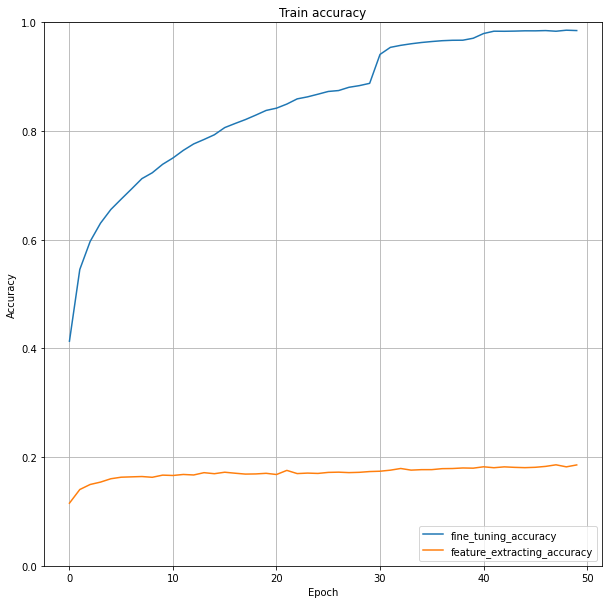

In [25]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

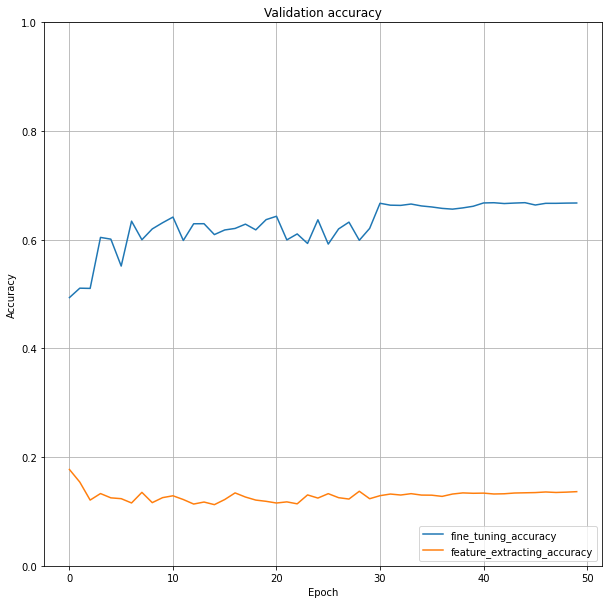

In [28]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

In [29]:
labelsPercent = [1, 2, 3, 5, 10, 25, 50, 100]

In [30]:
def shuffle_examples():
    #Перемешивание датасета для выбора размеченных экземпляров, т.к. выбираются первые n элементов
    for i in range(len(examplesForClass)):
        random.shuffle(examplesForClass[i])

In [31]:
def generate_labeled_unlabeled(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    #labeled_nums = [rotations_num * i for i in range(5000 - percent * 50, 5000)]
    labeled_nums = [i for i in range((5000 - percent * 50) * rotations_num, 5000 * rotations_num)]
    unlabeled_nums = [i for i in range((5000 - percent * 50) * rotations_num)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [32]:
def generate_augmented_labeled_unlabeled(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    #labeled_nums = [rotations_num * i for i in range(5000 - percent * 50, 5000)]
    labeled_nums = [i for i in range((5000 - percent * 50) * augment_num, 5000 * augment_num)]
    unlabeled_nums = [i for i in range((5000 - percent * 50) * augment_num)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [33]:
def self_supervised_train(unlabeled, percent, use_datagen = False, **kwargs):
    if percent >= 100:
        return None
    
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    if use_datagen:
        log = model.fit(kwargs['datagen'].flow(np.asarray([combined_data[i] for i in unlabeled]), 
                    np.asarray([combined_labels[i] for i in unlabeled]),
                    batch_size = selfsupervised_batch_size),
                    epochs = selfsupervised_epochs, 
                    steps_per_epoch = len(unlabeled) // selfsupervised_batch_size,
                    shuffle = True,
                    #callbacks = [LearningRateScheduler(lr_schedule_conv)],
                            validation_data = (np.asarray(combined_data[50000 * rotations_num:]), 
                                               np.asarray(combined_labels[50000 * rotations_num:])))
    else:    
        log = model.fit(np.asarray([combined_data[i] for i in unlabeled]) / 256., 
                    np.asarray([combined_labels[i] for i in unlabeled]), 
                    epochs = selfsupervised_epochs, 
                    batch_size = selfsupervised_batch_size, 
                    shuffle = True,
                    #callbacks = [LearningRateScheduler(lr_schedule_conv)],
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)])  / 256., 
                                               np.asarray([combined_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    model.save(saved_name + "_" + str(percent))
    
    return log

In [34]:
def fine_tune(labeled, percent, train_features = True, use_features = True, use_datagen = False, **kwargs):
    #cls_model = get_cls_model(saved_name + "_" + str(percent))
    cls_model = get_cls_model(saved_name, use_features, percent)
    
    if not train_features:
        flag = False
        for l in cls_model.layers:
            l.trainable = flag
            if l.name == feature_layer or l.name == feature_layer_trained:
                flag = True
                
    cls_model.summary()
            
    cls_model.compile(optimizer = optimizers.Adam(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
    if use_datagen:
        print('Datagen is used...')
        cls_log = cls_model.fit(kwargs['datagen'].flow(np.asarray([combined_data[i] for i in labeled]), 
                            np.asarray([true_labels[i] for i in labeled]),
                            batch_size = supervised_batch_size), 
                            epochs = supervised_epochs,
                            steps_per_epoch = len(labeled) // supervised_batch_size, 
                            shuffle = True,
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)]) / 256., 
                                               np.asarray([true_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    else:
        cls_log = cls_model.fit(np.asarray([augmented_data[i] for i in labeled]) / 256., 
                            np.asarray([augmented_labels[i] for i in labeled]), 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, 
                            shuffle = True,
                            validation_data = (np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)])  / 256., 
                                               np.asarray([true_labels[(50000 + i) * rotations_num] for i in range(10000)])))
    
    return cls_log

In [35]:
def get_empty_model():
    #Непредобученная модель на случай использования всей разметки
    model = get_conv_model()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.save(saved_name + "_100")
    
    return get_cls_model(saved_name + "_100")

In [36]:
def my_preprocess(data):
    output = data / 256.0
    return output

In [37]:
aug_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=4,
    height_shift_range=4,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=my_preprocess)
aug_datagen.fit(combined_data)

In [38]:
print(dir(tf.image))

['ResizeMethod', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'adjust_brightness', 'adjust_contrast', 'adjust_gamma', 'adjust_hue', 'adjust_jpeg_quality', 'adjust_saturation', 'central_crop', 'combined_non_max_suppression', 'convert_image_dtype', 'crop_and_resize', 'crop_to_bounding_box', 'decode_and_crop_jpeg', 'decode_bmp', 'decode_gif', 'decode_image', 'decode_jpeg', 'decode_png', 'draw_bounding_boxes', 'encode_jpeg', 'encode_png', 'extract_glimpse', 'extract_jpeg_shape', 'extract_patches', 'flip_left_right', 'flip_up_down', 'generate_bounding_box_proposals', 'grayscale_to_rgb', 'hsv_to_rgb', 'image_gradients', 'is_jpeg', 'non_max_suppression', 'non_max_suppression_overlaps', 'non_max_suppression_padded', 'non_max_suppression_with_scores', 'pad_to_bounding_box', 'per_image_standardization', 'psnr', 'random_brightness', 'random_contrast', 'random_crop', 'random_flip_left_right', 'random_flip_up_down', 'r

In [39]:
augmented_data = np.zeros((50000 * augment_num, 32, 32, 3), dtype = np.float32)
augmented_labels = np.zeros((50000 * augment_num, 10), dtype = np.float32)

In [40]:
for i in range(50000):
    if i % 1000 == 0:
        print(i)
    augmented_data[i * augment_num] = combined_data[i * rotations_num]
    augmented_data[i * augment_num + 1] = tf.image.flip_up_down(tf.image.random_contrast(combined_data[i * rotations_num], 0.2, 0.7))
    augmented_data[i * augment_num + 2] = tf.image.flip_left_right(tf.image.random_contrast(combined_data[i * rotations_num], 0.2, 0.7))
    augmented_data[i * augment_num + 3] = tf.image.random_contrast(combined_data[i * rotations_num], 0.2, 0.7)
    augmented_data[i * augment_num + 4] = tf.image.flip_left_right(combined_data[i * rotations_num])
    augmented_data[i * augment_num + 5] = tf.image.flip_up_down(combined_data[i * rotations_num])
    augmented_data[i * augment_num + 6] = tf.image.random_hue(combined_data[i * rotations_num], 0.3)
    augmented_data[i * augment_num + 7] = tf.image.random_saturation(combined_data[i * rotations_num], 5, 10)
    augmented_data[i * augment_num + 8] = tf.image.flip_left_right(tf.image.random_hue(combined_data[i * rotations_num], 0.3))
    augmented_data[i * augment_num + 9] = tf.image.flip_left_right(tf.image.random_saturation(combined_data[i * rotations_num], 5, 10))
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [41]:
for i in range(50000):
    for j in range(augment_num):
            augmented_labels[i * augment_num + j] = true_labels[i * rotations_num]

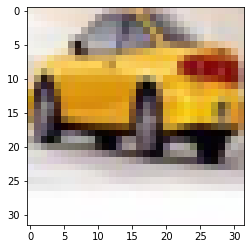

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


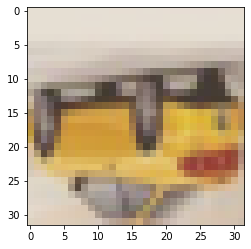

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


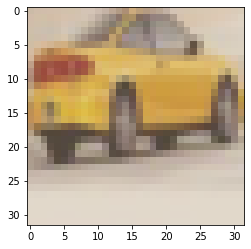

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


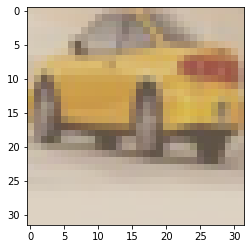

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


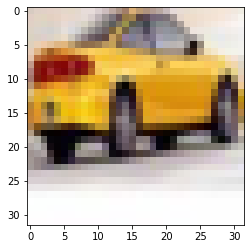

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


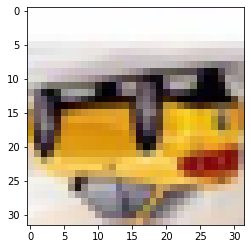

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


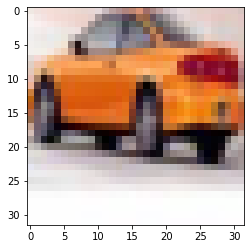

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


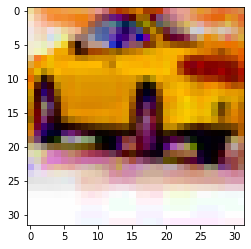

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


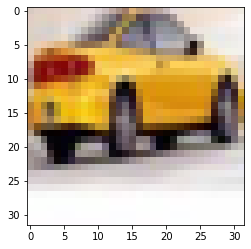

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


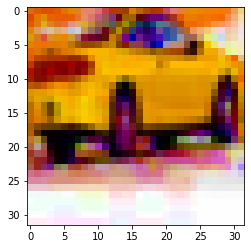

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
r = random.randint(0, 50000)
for i in range(augment_num):
    plt.imshow(augmented_data[r * augment_num + i].astype(int))
    plt.show()
    print(augmented_labels[r * augment_num + i])

In [43]:
augmentedExamplesForClass = []
for i in range(10):
    augmentedExamplesForClass.append([j for j in range(50000 * augment_num) if np.where(augmented_labels[j] == 1)[0][0] == i])

In [44]:
examplesForClass = []
for i in range(10):
    examplesForClass.append([j for j in range(50000 * rotations_num) if np.where(true_labels[j] == 1)[0][0] == i])

In [45]:
labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, 0, False)
self_supervised_train(unlabeled, 0)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 200000 samples, validate on 10000 samples
Epoch 1/80
200000/200000 [==============================] - 31s 157us/sample - loss: 2.4446 - accuracy: 0.5756 - val_loss: 1.8339 - val_accuracy: 0.5717
Epoch 2/80
200000/200000 [==============================] - 29s 145us/sample - loss: 1.7002 - accuracy: 0.6559 - val_loss: 1.3682 - val_accuracy: 0.8283
Epoch 3/80
200000/200000 [==============================] - 30s 150us/sample - loss: 1.6393 - accuracy: 0.6969 - val_loss: 1.6253 - val_accuracy: 0.6940
Epoch 4/80
200000/200000 [==============================] - 29s 147us/sample - loss: 1.5753 - accuracy: 0.7271 - val_loss: 1.4542 - val_accuracy: 0.7775
Epoch 5/80
200000/200000 [==============================] - 28s 142us/sample - loss: 1.5071 - accuracy: 0.7506 - val_loss: 1.8867 - val_accuracy: 0.6051
Epoch 6/80
200000/200000 [==============================] - 29s 143us/sample - loss: 1.4498 - accuracy: 0.7673 - val_loss: 1.6653 - val_accuracy: 0.6804
Epoch 7/80
200000/200000 [=====

Epoch 54/80
200000/200000 [==============================] - 29s 143us/sample - loss: 0.5996 - accuracy: 0.9422 - val_loss: 1.0986 - val_accuracy: 0.8178
Epoch 55/80
200000/200000 [==============================] - 29s 145us/sample - loss: 0.5900 - accuracy: 0.9432 - val_loss: 1.3480 - val_accuracy: 0.7525
Epoch 56/80
200000/200000 [==============================] - 30s 148us/sample - loss: 0.5881 - accuracy: 0.9442 - val_loss: 1.3888 - val_accuracy: 0.7440
Epoch 57/80
200000/200000 [==============================] - 29s 146us/sample - loss: 0.5850 - accuracy: 0.9448 - val_loss: 1.1901 - val_accuracy: 0.7957
Epoch 58/80
200000/200000 [==============================] - 29s 144us/sample - loss: 0.5805 - accuracy: 0.9453 - val_loss: 1.4212 - val_accuracy: 0.7393
Epoch 59/80
200000/200000 [==============================] - 29s 145us/sample - loss: 0.5771 - accuracy: 0.9465 - val_loss: 1.4947 - val_accuracy: 0.7267
Epoch 60/80
200000/200000 [==============================] - 28s 142us/sampl

In [46]:
logs = []
cls_logs = []

In [47]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    #if not os.path.isfile(saved_name + "_" + str(p)):
    
    if not os.path.isfile(saved_name):
        logs.append(self_supervised_train(unlabeled, p))
    cls_logs.append(fine_tune(labeled, p, True))        

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 198000 samples, validate on 10000 samples
Epoch 1/80
198000/198000 [==============================] - 30s 151us/sample - loss: 2.4493 - accuracy: 0.5758 - val_loss: 1.9762 - val_accuracy: 0.5287
Epoch 2/80
198000/198000 [==============================] - 28s 140us/sample - loss: 1.7048 - accuracy: 0.6606 - val_loss: 2.2252 - val_accuracy: 0.3625
Epoch 3/80
198000/198000 [==============================] - 28s 139us/sample - loss: 1.6404 - accuracy: 0.7024 - val_loss: 1.4969 - val_accuracy: 0.7956
Epoch 4/80
198000/198000 [==============================] - 28s 141us/sample - loss: 1.5709 - accuracy: 0.7340 - val_loss: 1.6849 - val_accuracy: 0.7421
Epoch 5/80
198000/198000 [==============================] - 28s 139us/sample - loss: 1.5068 - accuracy: 0.7549 - val_loss: 2.0196 - val_accuracy: 0.5283
Epoch 6/80
198000/198000 [==============================] - 28s 140us/sample - loss: 1.4436 - accuracy: 0.7727 - val_loss: 1.8819 - val_accuracy: 0.6272
Epoch 7/80
198000/198000 [=====

Epoch 54/80
198000/198000 [==============================] - 27s 139us/sample - loss: 0.5993 - accuracy: 0.9425 - val_loss: 0.9656 - val_accuracy: 0.8492
Epoch 55/80
198000/198000 [==============================] - 28s 141us/sample - loss: 0.5968 - accuracy: 0.9428 - val_loss: 1.3710 - val_accuracy: 0.7411
Epoch 56/80
198000/198000 [==============================] - 27s 139us/sample - loss: 0.5889 - accuracy: 0.9453 - val_loss: 1.4346 - val_accuracy: 0.7426
Epoch 57/80
198000/198000 [==============================] - 28s 140us/sample - loss: 0.5844 - accuracy: 0.9457 - val_loss: 1.3983 - val_accuracy: 0.7443
Epoch 58/80
198000/198000 [==============================] - 28s 139us/sample - loss: 0.5845 - accuracy: 0.9452 - val_loss: 1.3852 - val_accuracy: 0.7581
Epoch 59/80
198000/198000 [==============================] - 28s 141us/sample - loss: 0.5782 - accuracy: 0.9471 - val_loss: 1.0295 - val_accuracy: 0.8479
Epoch 60/80
198000/198000 [==============================] - 28s 141us/sampl

Train on 2000 samples, validate on 10000 samples
Epoch 1/50
2000/2000 [==============================] - 2s 1ms/sample - loss: 6.1983 - accuracy: 0.2470 - val_loss: 8.0786 - val_accuracy: 0.1000
Epoch 2/50
2000/2000 [==============================] - 1s 366us/sample - loss: 5.4656 - accuracy: 0.4970 - val_loss: 7.5415 - val_accuracy: 0.1000
Epoch 3/50
2000/2000 [==============================] - 1s 359us/sample - loss: 5.0422 - accuracy: 0.6380 - val_loss: 7.0538 - val_accuracy: 0.1244
Epoch 4/50
2000/2000 [==============================] - 1s 368us/sample - loss: 4.6034 - accuracy: 0.7655 - val_loss: 6.6608 - val_accuracy: 0.1000
Epoch 5/50
2000/2000 [==============================] - 1s 365us/sample - loss: 4.2143 - accuracy: 0.8480 - val_loss: 6.4291 - val_accuracy: 0.1000
Epoch 6/50
2000/2000 [==============================] - 1s 368us/sample - loss: 3.8799 - accuracy: 0.8940 - val_loss: 6.7509 - val_accuracy: 0.1000
Epoch 7/50
2000/2000 [==============================] - 1s 366us/

Train on 196000 samples, validate on 10000 samples
Epoch 1/80
196000/196000 [==============================] - 30s 151us/sample - loss: 2.4631 - accuracy: 0.5740 - val_loss: 1.7482 - val_accuracy: 0.6160
Epoch 2/80
196000/196000 [==============================] - 28s 140us/sample - loss: 1.7387 - accuracy: 0.6583 - val_loss: 1.2615 - val_accuracy: 0.8746
Epoch 3/80
196000/196000 [==============================] - 28s 142us/sample - loss: 1.6740 - accuracy: 0.7010 - val_loss: 1.4488 - val_accuracy: 0.7565
Epoch 4/80
196000/196000 [==============================] - 27s 140us/sample - loss: 1.5979 - accuracy: 0.7301 - val_loss: 1.7249 - val_accuracy: 0.6989
Epoch 5/80
196000/196000 [==============================] - 27s 139us/sample - loss: 1.5344 - accuracy: 0.7541 - val_loss: 1.4197 - val_accuracy: 0.7990
Epoch 6/80
196000/196000 [==============================] - 28s 141us/sample - loss: 1.4741 - accuracy: 0.7710 - val_loss: 1.3302 - val_accuracy: 0.8139
Epoch 7/80
196000/196000 [=====

Epoch 54/80
196000/196000 [==============================] - 27s 140us/sample - loss: 0.6085 - accuracy: 0.9419 - val_loss: 1.2648 - val_accuracy: 0.7730
Epoch 55/80
196000/196000 [==============================] - 28s 141us/sample - loss: 0.6051 - accuracy: 0.9429 - val_loss: 1.2304 - val_accuracy: 0.7701
Epoch 56/80
196000/196000 [==============================] - 28s 141us/sample - loss: 0.5990 - accuracy: 0.9445 - val_loss: 1.0543 - val_accuracy: 0.8272
Epoch 57/80
196000/196000 [==============================] - 27s 140us/sample - loss: 0.5988 - accuracy: 0.9457 - val_loss: 1.2310 - val_accuracy: 0.7798
Epoch 58/80
196000/196000 [==============================] - 27s 139us/sample - loss: 0.5952 - accuracy: 0.9458 - val_loss: 1.0577 - val_accuracy: 0.8025
Epoch 59/80
196000/196000 [==============================] - 27s 139us/sample - loss: 0.5877 - accuracy: 0.9470 - val_loss: 1.1528 - val_accuracy: 0.8117
Epoch 60/80
196000/196000 [==============================] - 27s 140us/sampl

Train on 4000 samples, validate on 10000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 601us/sample - loss: 6.1349 - accuracy: 0.2885 - val_loss: 9.2522 - val_accuracy: 0.1064
Epoch 2/50
4000/4000 [==============================] - 1s 232us/sample - loss: 5.3271 - accuracy: 0.5145 - val_loss: 8.4348 - val_accuracy: 0.1000
Epoch 3/50
4000/4000 [==============================] - 1s 235us/sample - loss: 4.6799 - accuracy: 0.6678 - val_loss: 7.4296 - val_accuracy: 0.1000
Epoch 4/50
4000/4000 [==============================] - 1s 231us/sample - loss: 4.1574 - accuracy: 0.7682 - val_loss: 6.3004 - val_accuracy: 0.1000
Epoch 5/50
4000/4000 [==============================] - 1s 235us/sample - loss: 3.7209 - accuracy: 0.8415 - val_loss: 6.2669 - val_accuracy: 0.1000
Epoch 6/50
4000/4000 [==============================] - 1s 237us/sample - loss: 3.3794 - accuracy: 0.8817 - val_loss: 5.7653 - val_accuracy: 0.1000
Epoch 7/50
4000/4000 [==============================] - 1s 234u

Train on 194000 samples, validate on 10000 samples
Epoch 1/80
194000/194000 [==============================] - 30s 154us/sample - loss: 2.4468 - accuracy: 0.5786 - val_loss: 1.7751 - val_accuracy: 0.5844
Epoch 2/80
194000/194000 [==============================] - 28s 144us/sample - loss: 1.7122 - accuracy: 0.6612 - val_loss: 1.8818 - val_accuracy: 0.6066
Epoch 3/80
194000/194000 [==============================] - 28s 142us/sample - loss: 1.6413 - accuracy: 0.7026 - val_loss: 1.3714 - val_accuracy: 0.8022
Epoch 4/80
194000/194000 [==============================] - 28s 144us/sample - loss: 1.5673 - accuracy: 0.7330 - val_loss: 1.5646 - val_accuracy: 0.7111
Epoch 5/80
194000/194000 [==============================] - 28s 144us/sample - loss: 1.5032 - accuracy: 0.7538 - val_loss: 1.6296 - val_accuracy: 0.6920
Epoch 6/80
194000/194000 [==============================] - 28s 142us/sample - loss: 1.4431 - accuracy: 0.7724 - val_loss: 1.6602 - val_accuracy: 0.6910
Epoch 7/80
194000/194000 [=====

Epoch 54/80
194000/194000 [==============================] - 28s 143us/sample - loss: 0.6017 - accuracy: 0.9435 - val_loss: 1.2332 - val_accuracy: 0.7747
Epoch 55/80
194000/194000 [==============================] - 28s 144us/sample - loss: 0.5966 - accuracy: 0.9441 - val_loss: 1.1893 - val_accuracy: 0.7965
Epoch 56/80
194000/194000 [==============================] - 28s 143us/sample - loss: 0.5902 - accuracy: 0.9456 - val_loss: 0.9918 - val_accuracy: 0.8401
Epoch 57/80
194000/194000 [==============================] - 27s 140us/sample - loss: 0.5839 - accuracy: 0.9465 - val_loss: 1.2699 - val_accuracy: 0.7691
Epoch 58/80
194000/194000 [==============================] - 28s 144us/sample - loss: 0.5842 - accuracy: 0.9464 - val_loss: 1.4603 - val_accuracy: 0.7304
Epoch 59/80
194000/194000 [==============================] - 28s 144us/sample - loss: 0.5780 - accuracy: 0.9482 - val_loss: 1.5564 - val_accuracy: 0.7056
Epoch 60/80
194000/194000 [==============================] - 28s 144us/sampl

Train on 6000 samples, validate on 10000 samples
Epoch 1/50
6000/6000 [==============================] - 3s 451us/sample - loss: 6.0010 - accuracy: 0.3162 - val_loss: 7.8474 - val_accuracy: 0.1000
Epoch 2/50
6000/6000 [==============================] - 1s 206us/sample - loss: 5.0281 - accuracy: 0.5620 - val_loss: 6.8129 - val_accuracy: 0.1000
Epoch 3/50
6000/6000 [==============================] - 1s 207us/sample - loss: 4.3240 - accuracy: 0.6942 - val_loss: 6.3710 - val_accuracy: 0.1000
Epoch 4/50
6000/6000 [==============================] - 1s 207us/sample - loss: 3.7866 - accuracy: 0.7858 - val_loss: 5.9952 - val_accuracy: 0.1000
Epoch 5/50
6000/6000 [==============================] - 1s 210us/sample - loss: 3.4336 - accuracy: 0.8385 - val_loss: 5.6514 - val_accuracy: 0.1000
Epoch 6/50
6000/6000 [==============================] - 1s 198us/sample - loss: 3.1909 - accuracy: 0.8695 - val_loss: 5.6041 - val_accuracy: 0.1363
Epoch 7/50
6000/6000 [==============================] - 1s 190u

Train on 190000 samples, validate on 10000 samples
Epoch 1/80
190000/190000 [==============================] - 30s 155us/sample - loss: 2.4501 - accuracy: 0.5750 - val_loss: 1.4018 - val_accuracy: 0.7969
Epoch 2/80
190000/190000 [==============================] - 27s 144us/sample - loss: 1.7060 - accuracy: 0.6553 - val_loss: 2.0926 - val_accuracy: 0.4306
Epoch 3/80
190000/190000 [==============================] - 28s 145us/sample - loss: 1.6506 - accuracy: 0.6943 - val_loss: 1.4251 - val_accuracy: 0.7775
Epoch 4/80
190000/190000 [==============================] - 27s 143us/sample - loss: 1.5791 - accuracy: 0.7235 - val_loss: 1.7270 - val_accuracy: 0.6524
Epoch 5/80
190000/190000 [==============================] - 27s 144us/sample - loss: 1.5164 - accuracy: 0.7465 - val_loss: 1.5224 - val_accuracy: 0.7409
Epoch 6/80
190000/190000 [==============================] - 27s 144us/sample - loss: 1.4634 - accuracy: 0.7633 - val_loss: 1.3442 - val_accuracy: 0.8028
Epoch 7/80
190000/190000 [=====

Epoch 54/80
190000/190000 [==============================] - 27s 143us/sample - loss: 0.5985 - accuracy: 0.9420 - val_loss: 1.2172 - val_accuracy: 0.7937
Epoch 55/80
190000/190000 [==============================] - 27s 143us/sample - loss: 0.5973 - accuracy: 0.9432 - val_loss: 1.1646 - val_accuracy: 0.8155
Epoch 56/80
190000/190000 [==============================] - 27s 144us/sample - loss: 0.5920 - accuracy: 0.9435 - val_loss: 1.3695 - val_accuracy: 0.7614
Epoch 57/80
190000/190000 [==============================] - 27s 144us/sample - loss: 0.5870 - accuracy: 0.9455 - val_loss: 1.1929 - val_accuracy: 0.7959
Epoch 58/80
190000/190000 [==============================] - 27s 144us/sample - loss: 0.5835 - accuracy: 0.9460 - val_loss: 1.2904 - val_accuracy: 0.7721
Epoch 59/80
190000/190000 [==============================] - 27s 144us/sample - loss: 0.5815 - accuracy: 0.9461 - val_loss: 1.4613 - val_accuracy: 0.7584
Epoch 60/80
190000/190000 [==============================] - 27s 143us/sampl

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 3s 308us/sample - loss: 5.8603 - accuracy: 0.3465 - val_loss: 7.8085 - val_accuracy: 0.1000
Epoch 2/50
10000/10000 [==============================] - 2s 157us/sample - loss: 4.6878 - accuracy: 0.5810 - val_loss: 6.7138 - val_accuracy: 0.1000
Epoch 3/50
10000/10000 [==============================] - 2s 158us/sample - loss: 3.9752 - accuracy: 0.6951 - val_loss: 6.1530 - val_accuracy: 0.1000
Epoch 4/50
10000/10000 [==============================] - 2s 156us/sample - loss: 3.7057 - accuracy: 0.7538 - val_loss: 5.7441 - val_accuracy: 0.0999
Epoch 5/50
10000/10000 [==============================] - 2s 157us/sample - loss: 3.5567 - accuracy: 0.7966 - val_loss: 5.8700 - val_accuracy: 0.1013
Epoch 6/50
10000/10000 [==============================] - 2s 153us/sample - loss: 3.4920 - accuracy: 0.8165 - val_loss: 5.9660 - val_accuracy: 0.1061
Epoch 7/50
10000/10000 [==========================

Train on 180000 samples, validate on 10000 samples
Epoch 1/80
180000/180000 [==============================] - 27s 151us/sample - loss: 2.5245 - accuracy: 0.5688 - val_loss: 1.7705 - val_accuracy: 0.6704
Epoch 2/80
180000/180000 [==============================] - 25s 142us/sample - loss: 1.7311 - accuracy: 0.6518 - val_loss: 1.3228 - val_accuracy: 0.8033
Epoch 3/80
180000/180000 [==============================] - 25s 142us/sample - loss: 1.6713 - accuracy: 0.6923 - val_loss: 1.8674 - val_accuracy: 0.5665
Epoch 4/80
180000/180000 [==============================] - 25s 142us/sample - loss: 1.6083 - accuracy: 0.7220 - val_loss: 1.9728 - val_accuracy: 0.5537
Epoch 5/80
180000/180000 [==============================] - 26s 142us/sample - loss: 1.5422 - accuracy: 0.7438 - val_loss: 1.6445 - val_accuracy: 0.7022
Epoch 6/80
180000/180000 [==============================] - 26s 143us/sample - loss: 1.4847 - accuracy: 0.7612 - val_loss: 1.3528 - val_accuracy: 0.8029
Epoch 7/80
180000/180000 [=====

Epoch 54/80
180000/180000 [==============================] - 25s 141us/sample - loss: 0.6084 - accuracy: 0.9435 - val_loss: 1.1345 - val_accuracy: 0.8059
Epoch 55/80
180000/180000 [==============================] - 26s 142us/sample - loss: 0.6034 - accuracy: 0.9446 - val_loss: 1.1710 - val_accuracy: 0.7958
Epoch 56/80
180000/180000 [==============================] - 26s 142us/sample - loss: 0.6016 - accuracy: 0.9440 - val_loss: 1.3023 - val_accuracy: 0.7661
Epoch 57/80
180000/180000 [==============================] - 25s 141us/sample - loss: 0.5905 - accuracy: 0.9459 - val_loss: 1.4095 - val_accuracy: 0.7609
Epoch 58/80
180000/180000 [==============================] - 25s 141us/sample - loss: 0.5890 - accuracy: 0.9462 - val_loss: 1.3839 - val_accuracy: 0.7506
Epoch 59/80
180000/180000 [==============================] - 26s 143us/sample - loss: 0.5846 - accuracy: 0.9477 - val_loss: 1.2929 - val_accuracy: 0.7649
Epoch 60/80
180000/180000 [==============================] - 26s 143us/sampl

Train on 20000 samples, validate on 10000 samples
Epoch 1/50
20000/20000 [==============================] - 4s 211us/sample - loss: 5.4271 - accuracy: 0.4038 - val_loss: 5.9755 - val_accuracy: 0.1000
Epoch 2/50
20000/20000 [==============================] - 3s 132us/sample - loss: 4.1190 - accuracy: 0.6008 - val_loss: 5.5904 - val_accuracy: 0.1000
Epoch 3/50
20000/20000 [==============================] - 3s 128us/sample - loss: 3.7823 - accuracy: 0.6697 - val_loss: 6.4918 - val_accuracy: 0.1060
Epoch 4/50
20000/20000 [==============================] - 3s 128us/sample - loss: 3.6673 - accuracy: 0.7161 - val_loss: 5.4729 - val_accuracy: 0.2256
Epoch 5/50
20000/20000 [==============================] - 3s 130us/sample - loss: 3.6273 - accuracy: 0.7487 - val_loss: 5.0482 - val_accuracy: 0.3705
Epoch 6/50
20000/20000 [==============================] - 3s 128us/sample - loss: 3.5693 - accuracy: 0.7734 - val_loss: 4.2887 - val_accuracy: 0.5383
Epoch 7/50
20000/20000 [==========================

Train on 150000 samples, validate on 10000 samples
Epoch 1/80
150000/150000 [==============================] - 24s 157us/sample - loss: 2.6584 - accuracy: 0.5618 - val_loss: 3.1537 - val_accuracy: 0.1376
Epoch 2/80
150000/150000 [==============================] - 22s 145us/sample - loss: 1.7688 - accuracy: 0.6399 - val_loss: 2.0279 - val_accuracy: 0.5077
Epoch 3/80
150000/150000 [==============================] - 22s 146us/sample - loss: 1.6890 - accuracy: 0.6747 - val_loss: 1.4955 - val_accuracy: 0.7466
Epoch 4/80
150000/150000 [==============================] - 22s 146us/sample - loss: 1.6421 - accuracy: 0.7037 - val_loss: 1.9042 - val_accuracy: 0.5802
Epoch 5/80
150000/150000 [==============================] - 22s 144us/sample - loss: 1.5868 - accuracy: 0.7294 - val_loss: 1.5532 - val_accuracy: 0.7261
Epoch 6/80
150000/150000 [==============================] - 22s 148us/sample - loss: 1.5256 - accuracy: 0.7491 - val_loss: 1.3938 - val_accuracy: 0.8030
Epoch 7/80
150000/150000 [=====

Epoch 54/80
150000/150000 [==============================] - 22s 145us/sample - loss: 0.6029 - accuracy: 0.9464 - val_loss: 1.4999 - val_accuracy: 0.7175
Epoch 55/80
150000/150000 [==============================] - 22s 145us/sample - loss: 0.5971 - accuracy: 0.9475 - val_loss: 0.8095 - val_accuracy: 0.8914
Epoch 56/80
150000/150000 [==============================] - 22s 144us/sample - loss: 0.5891 - accuracy: 0.9480 - val_loss: 0.9916 - val_accuracy: 0.8487
Epoch 57/80
150000/150000 [==============================] - 22s 146us/sample - loss: 0.5868 - accuracy: 0.9490 - val_loss: 1.2952 - val_accuracy: 0.7758
Epoch 58/80
150000/150000 [==============================] - 22s 145us/sample - loss: 0.5808 - accuracy: 0.9507 - val_loss: 1.5408 - val_accuracy: 0.7338
Epoch 59/80
150000/150000 [==============================] - 22s 145us/sample - loss: 0.5729 - accuracy: 0.9510 - val_loss: 1.2554 - val_accuracy: 0.7807
Epoch 60/80
150000/150000 [==============================] - 22s 145us/sampl

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 147us/sample - loss: 4.6610 - accuracy: 0.4772 - val_loss: 5.3534 - val_accuracy: 0.1000
Epoch 2/50
50000/50000 [==============================] - 6s 116us/sample - loss: 3.6696 - accuracy: 0.6062 - val_loss: 4.2696 - val_accuracy: 0.3832
Epoch 3/50
50000/50000 [==============================] - 6s 117us/sample - loss: 3.4813 - accuracy: 0.6448 - val_loss: 3.4544 - val_accuracy: 0.6423
Epoch 4/50
50000/50000 [==============================] - 6s 118us/sample - loss: 3.4146 - accuracy: 0.6716 - val_loss: 3.4412 - val_accuracy: 0.6610
Epoch 5/50
50000/50000 [==============================] - 6s 114us/sample - loss: 3.3820 - accuracy: 0.6918 - val_loss: 3.4401 - val_accuracy: 0.6746
Epoch 6/50
50000/50000 [==============================] - 6s 114us/sample - loss: 3.3924 - accuracy: 0.7080 - val_loss: 3.4598 - val_accuracy: 0.6844
Epoch 7/50
50000/50000 [==========================

Train on 100000 samples, validate on 10000 samples
Epoch 1/80
100000/100000 [==============================] - 16s 164us/sample - loss: 2.9715 - accuracy: 0.5320 - val_loss: 2.3379 - val_accuracy: 0.4203
Epoch 2/80
100000/100000 [==============================] - 14s 144us/sample - loss: 1.9060 - accuracy: 0.6109 - val_loss: 2.0761 - val_accuracy: 0.5047
Epoch 3/80
100000/100000 [==============================] - 14s 144us/sample - loss: 1.7460 - accuracy: 0.6428 - val_loss: 1.5171 - val_accuracy: 0.7464
Epoch 4/80
100000/100000 [==============================] - 14s 142us/sample - loss: 1.6978 - accuracy: 0.6698 - val_loss: 2.3302 - val_accuracy: 0.3863
Epoch 5/80
100000/100000 [==============================] - 15s 145us/sample - loss: 1.6759 - accuracy: 0.6929 - val_loss: 2.0009 - val_accuracy: 0.5749
Epoch 6/80
100000/100000 [==============================] - 14s 144us/sample - loss: 1.6389 - accuracy: 0.7146 - val_loss: 2.0084 - val_accuracy: 0.6131
Epoch 7/80
100000/100000 [=====

Epoch 54/80
100000/100000 [==============================] - 14s 142us/sample - loss: 0.6473 - accuracy: 0.9505 - val_loss: 1.5218 - val_accuracy: 0.7332
Epoch 55/80
100000/100000 [==============================] - 14s 144us/sample - loss: 0.6340 - accuracy: 0.9512 - val_loss: 1.3973 - val_accuracy: 0.7687
Epoch 56/80
100000/100000 [==============================] - 15s 148us/sample - loss: 0.6332 - accuracy: 0.9525 - val_loss: 1.8263 - val_accuracy: 0.7009
Epoch 57/80
100000/100000 [==============================] - 14s 143us/sample - loss: 0.6223 - accuracy: 0.9539 - val_loss: 1.4504 - val_accuracy: 0.7706
Epoch 58/80
100000/100000 [==============================] - 14s 144us/sample - loss: 0.6115 - accuracy: 0.9538 - val_loss: 1.8674 - val_accuracy: 0.6633
Epoch 59/80
100000/100000 [==============================] - 14s 145us/sample - loss: 0.6080 - accuracy: 0.9559 - val_loss: 1.5859 - val_accuracy: 0.7290
Epoch 60/80
100000/100000 [==============================] - 14s 144us/sampl

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 17s 170us/sample - loss: 3.7746 - accuracy: 0.4978 - val_loss: 3.3592 - val_accuracy: 0.4125
Epoch 2/50
100000/100000 [==============================] - 15s 151us/sample - loss: 2.6458 - accuracy: 0.6385 - val_loss: 2.4379 - val_accuracy: 0.6928
Epoch 3/50
100000/100000 [==============================] - 15s 148us/sample - loss: 2.4413 - accuracy: 0.6866 - val_loss: 2.4183 - val_accuracy: 0.6849
Epoch 4/50
100000/100000 [==============================] - 15s 150us/sample - loss: 2.3548 - accuracy: 0.7221 - val_loss: 2.3931 - val_accuracy: 0.7052
Epoch 5/50
100000/100000 [==============================] - 15s 150us/sample - loss: 2.2917 - accuracy: 0.7474 - val_loss: 2.5171 - val_accuracy: 0.6948
Epoch 6/50
100000/100000 [==============================] - 15s 149us/sample - loss: 2.2295 - accuracy: 0.7741 - val_loss: 2.3804 - val_accuracy: 0.7301
Epoch 7/50
100000/100000 [=====

Train on 200000 samples, validate on 10000 samples
Epoch 1/50
200000/200000 [==============================] - 30s 152us/sample - loss: 3.1762 - accuracy: 0.5516 - val_loss: 2.3630 - val_accuracy: 0.6886
Epoch 2/50
200000/200000 [==============================] - 28s 141us/sample - loss: 2.3756 - accuracy: 0.6738 - val_loss: 2.1688 - val_accuracy: 0.7296
Epoch 3/50
200000/200000 [==============================] - 28s 141us/sample - loss: 2.2656 - accuracy: 0.7169 - val_loss: 2.1539 - val_accuracy: 0.7425
Epoch 4/50
200000/200000 [==============================] - 28s 140us/sample - loss: 2.1824 - accuracy: 0.7463 - val_loss: 2.3067 - val_accuracy: 0.7158
Epoch 5/50
200000/200000 [==============================] - 28s 141us/sample - loss: 2.1079 - accuracy: 0.7700 - val_loss: 2.2150 - val_accuracy: 0.7352
Epoch 6/50
200000/200000 [==============================] - 29s 143us/sample - loss: 2.0399 - accuracy: 0.7875 - val_loss: 2.1802 - val_accuracy: 0.7408
Epoch 7/50
200000/200000 [=====

In [48]:
#Self-supervised with augmentation

In [49]:
for p in labelsPercent:
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    print(len(labeled), len(unlabeled))
    cls_logs.append(fine_tune(labeled, p, True, True))        
#[0.5505, 0.6021, 0.6382, 0.6691, 0.7135, 0.7671, 0.8060, 0.8448]

5000 495000
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________

5000/5000 [==============================] - 1s 215us/sample - loss: 3.4974 - accuracy: 0.8916 - val_loss: 5.9609 - val_accuracy: 0.1247
Epoch 11/50
5000/5000 [==============================] - 1s 212us/sample - loss: 3.3928 - accuracy: 0.9032 - val_loss: 5.6167 - val_accuracy: 0.1641
Epoch 12/50
5000/5000 [==============================] - 1s 213us/sample - loss: 3.4405 - accuracy: 0.8930 - val_loss: 5.6547 - val_accuracy: 0.1043
Epoch 13/50
5000/5000 [==============================] - 1s 211us/sample - loss: 3.3159 - accuracy: 0.9144 - val_loss: 5.9331 - val_accuracy: 0.1236
Epoch 14/50
5000/5000 [==============================] - 1s 209us/sample - loss: 3.3149 - accuracy: 0.9160 - val_loss: 5.9983 - val_accuracy: 0.1245
Epoch 15/50
5000/5000 [==============================] - 1s 206us/sample - loss: 3.1125 - accuracy: 0.9364 - val_loss: 5.5172 - val_accuracy: 0.1758
Epoch 16/50
5000/5000 [==============================] - 1s 211us/sample - loss: 3.1469 - accuracy: 0.9176 - val_loss:

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 3s 312us/sample - loss: 5.7757 - accuracy: 0.3669 - val_loss: 6.8485 - val_accuracy: 0.1000
Epoch 2/50
10000/10000 [==============================] - 2s 162us/sample - loss: 4.6450 - accuracy: 0.5871 - val_loss: 6.4541 - val_accuracy: 0.1000
Epoch 3/50
10000/10000 [==============================] - 2s 158us/sample - loss: 4.0060 - accuracy: 0.7021 - val_loss: 6.5027 - val_accuracy: 0.1000
Epoch 4/50
10000/10000 [==============================] - 2s 154us/sample - loss: 3.6578 - accuracy: 0.7759 - val_loss: 6.6357 - val_accuracy: 0.1000
Epoch 5/50
10000/10000 [==============================] - 2s 156us/sample - loss: 3.5340 - accuracy: 0.7990 - val_loss: 6.3520 - val_accuracy: 0.1000
Epoch 6/50
10000/10000 [==============================] - 2s 157us/sample - loss: 3.4792 - accuracy: 0.8218 - val_loss: 6.9328 - val_accuracy: 0.1000
Epoch 7/50
10000/10000 [==========================

Train on 15000 samples, validate on 10000 samples
Epoch 1/50
15000/15000 [==============================] - 4s 248us/sample - loss: 5.6022 - accuracy: 0.3891 - val_loss: 6.5456 - val_accuracy: 0.1000
Epoch 2/50
15000/15000 [==============================] - 2s 138us/sample - loss: 4.3161 - accuracy: 0.6047 - val_loss: 5.9900 - val_accuracy: 0.1000
Epoch 3/50
15000/15000 [==============================] - 2s 141us/sample - loss: 3.8210 - accuracy: 0.6915 - val_loss: 6.3663 - val_accuracy: 0.1000
Epoch 4/50
15000/15000 [==============================] - 2s 139us/sample - loss: 3.6743 - accuracy: 0.7413 - val_loss: 5.9263 - val_accuracy: 0.1049
Epoch 5/50
15000/15000 [==============================] - 2s 141us/sample - loss: 3.5525 - accuracy: 0.7786 - val_loss: 6.2273 - val_accuracy: 0.1315
Epoch 6/50
15000/15000 [==============================] - 2s 138us/sample - loss: 3.5351 - accuracy: 0.7984 - val_loss: 5.9199 - val_accuracy: 0.1927
Epoch 7/50
15000/15000 [==========================

Train on 25000 samples, validate on 10000 samples
Epoch 1/50
25000/25000 [==============================] - 5s 190us/sample - loss: 5.1936 - accuracy: 0.4356 - val_loss: 6.5895 - val_accuracy: 0.1000
Epoch 2/50
25000/25000 [==============================] - 3s 126us/sample - loss: 3.9627 - accuracy: 0.6144 - val_loss: 6.3456 - val_accuracy: 0.1391
Epoch 3/50
25000/25000 [==============================] - 3s 126us/sample - loss: 3.7176 - accuracy: 0.6738 - val_loss: 5.7111 - val_accuracy: 0.1307
Epoch 4/50
25000/25000 [==============================] - 3s 126us/sample - loss: 3.6409 - accuracy: 0.7097 - val_loss: 4.7212 - val_accuracy: 0.3472
Epoch 5/50
25000/25000 [==============================] - 3s 127us/sample - loss: 3.5776 - accuracy: 0.7392 - val_loss: 4.1112 - val_accuracy: 0.5538
Epoch 6/50
25000/25000 [==============================] - 3s 125us/sample - loss: 3.5529 - accuracy: 0.7525 - val_loss: 4.0102 - val_accuracy: 0.6179
Epoch 7/50
25000/25000 [==========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 143us/sample - loss: 4.6272 - accuracy: 0.4847 - val_loss: 5.7316 - val_accuracy: 0.1000
Epoch 2/50
50000/50000 [==============================] - 6s 113us/sample - loss: 3.6161 - accuracy: 0.6169 - val_loss: 5.0064 - val_accuracy: 0.2092
Epoch 3/50
50000/50000 [==============================] - 6s 113us/sample - loss: 3.4576 - accuracy: 0.6568 - val_loss: 3.4289 - val_accuracy: 0.6488
Epoch 4/50
50000/50000 [==============================] - 6s 111us/sample - loss: 3.3802 - accuracy: 0.6808 - val_loss: 3.3426 - val_accuracy: 0.6801
Epoch 5/50
50000/50000 [==============================] - 6s 113us/sample - loss: 3.3367 - accuracy: 0.6979 - val_loss: 3.3567 - val_accuracy: 0.6773
Epoch 6/50
50000/50000 [==============================] - 6s 113us/sample - loss: 3.3163 - accuracy: 0.7105 - val_loss: 3.4044 - val_accuracy: 0.6845
Epoch 7/50
50000/50000 [==========================

Train on 125000 samples, validate on 10000 samples
Epoch 1/50
125000/125000 [==============================] - 15s 121us/sample - loss: 4.0142 - accuracy: 0.5319 - val_loss: 3.3890 - val_accuracy: 0.5786
Epoch 2/50
125000/125000 [==============================] - 13s 107us/sample - loss: 3.2527 - accuracy: 0.6199 - val_loss: 3.0300 - val_accuracy: 0.6711
Epoch 3/50
125000/125000 [==============================] - 13s 107us/sample - loss: 3.1853 - accuracy: 0.6450 - val_loss: 3.0289 - val_accuracy: 0.7097
Epoch 4/50
125000/125000 [==============================] - 13s 107us/sample - loss: 3.1872 - accuracy: 0.6638 - val_loss: 3.1911 - val_accuracy: 0.6677
Epoch 5/50
125000/125000 [==============================] - 13s 108us/sample - loss: 3.1854 - accuracy: 0.6774 - val_loss: 3.0335 - val_accuracy: 0.7207
Epoch 6/50
125000/125000 [==============================] - 14s 108us/sample - loss: 3.1758 - accuracy: 0.6890 - val_loss: 3.0691 - val_accuracy: 0.7327
Epoch 7/50
125000/125000 [=====

Train on 250000 samples, validate on 10000 samples
Epoch 1/50
250000/250000 [==============================] - 38s 152us/sample - loss: 3.0571 - accuracy: 0.5719 - val_loss: 2.3302 - val_accuracy: 0.6831
Epoch 2/50
250000/250000 [==============================] - 36s 143us/sample - loss: 2.3421 - accuracy: 0.6859 - val_loss: 2.2572 - val_accuracy: 0.7171
Epoch 3/50
250000/250000 [==============================] - 36s 143us/sample - loss: 2.2309 - accuracy: 0.7283 - val_loss: 2.1578 - val_accuracy: 0.7523
Epoch 4/50
250000/250000 [==============================] - 36s 146us/sample - loss: 2.1390 - accuracy: 0.7581 - val_loss: 2.0911 - val_accuracy: 0.7661
Epoch 5/50
250000/250000 [==============================] - 36s 144us/sample - loss: 2.0536 - accuracy: 0.7775 - val_loss: 2.0947 - val_accuracy: 0.7650
Epoch 6/50
250000/250000 [==============================] - 36s 145us/sample - loss: 1.9654 - accuracy: 0.7945 - val_loss: 2.0253 - val_accuracy: 0.7709
Epoch 7/50
250000/250000 [=====

Train on 500000 samples, validate on 10000 samples
Epoch 1/50
500000/500000 [==============================] - 72s 144us/sample - loss: 2.6919 - accuracy: 0.6198 - val_loss: 2.0629 - val_accuracy: 0.7419
Epoch 2/50
500000/500000 [==============================] - 70s 139us/sample - loss: 2.1792 - accuracy: 0.7209 - val_loss: 2.0608 - val_accuracy: 0.7549
Epoch 3/50
500000/500000 [==============================] - 70s 140us/sample - loss: 2.0334 - accuracy: 0.7567 - val_loss: 1.9546 - val_accuracy: 0.7736
Epoch 4/50
500000/500000 [==============================] - 69s 137us/sample - loss: 1.8989 - accuracy: 0.7804 - val_loss: 1.7861 - val_accuracy: 0.7974
Epoch 5/50
500000/500000 [==============================] - 69s 138us/sample - loss: 1.7734 - accuracy: 0.7976 - val_loss: 1.7892 - val_accuracy: 0.7821
Epoch 6/50
500000/500000 [==============================] - 69s 137us/sample - loss: 1.6626 - accuracy: 0.8100 - val_loss: 1.6954 - val_accuracy: 0.7954
Epoch 7/50
500000/500000 [=====

In [50]:
for i in range(len(cls_logs)):
    print(cls_logs[i].history)

{'loss': [6.198288536071777, 5.465572204589844, 5.042212745666504, 4.603378246307373, 4.21432876777649, 3.8798529510498048, 3.5870174255371094, 3.3245502891540526, 3.0923918476104735, 2.8729465045928957, 2.6541122608184815, 2.461081949234009, 2.2994060401916503, 2.1756460342407227, 2.091653762817383, 2.07822741317749, 2.0805465431213377, 2.0821636981964113, 2.08416300201416, 2.07394863319397, 2.0592278480529784, 2.0677625732421876, 2.071196897506714, 2.0665870418548584, 2.092849552154541, 2.0844737071990966, 2.0836500205993653, 2.081047088623047, 2.1038965129852296, 2.0963546504974366, 2.0914951343536377, 2.087072002410889, 2.088178394317627, 2.04937961769104, 2.0114091358184814, 2.0079333381652833, 2.0066117782592774, 2.009059087753296, 2.0019045581817627, 2.0090810737609863, 2.0138811073303224, 2.027307514190674, 2.053928695678711, 2.063140110015869, 2.056549615859985, 2.042499235153198, 1.9891199359893799, 1.9006591749191284, 1.794421983718872, 1.732493698120117], 'accuracy': [0.247

In [51]:
feat_log = self_supervised_train([i for i in range(50000 * rotations_num)], 0)

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Train on 200000 samples, validate on 10000 samples
Epoch 1/80
200000/200000 [==============================] - 30s 149us/sample - loss: 2.4366 - accuracy: 0.5804 - val_loss: 1.6067 - val_accuracy: 0.6969
Epoch 2/80
200000/200000 [==============================] - 28s 139us/sample - loss: 1.7046 - accuracy: 0.6612 - val_loss: 1.9710 - val_accuracy: 0.5022
Epoch 3/80
200000/200000 [==============================] - 28s 139us/sample - loss: 1.6477 - accuracy: 0.6997 - val_loss: 1.2934 - val_accuracy: 0.8277
Epoch 4/80
200000/200000 [==============================] - 28s 140us/sample - loss: 1.5777 - accuracy: 0.7292 - val_loss: 1.7631 - val_accuracy: 0.6290
Epoch 5/80
200000/200000 [==============================] - 28s 140us/sample - loss: 1.5175 - accuracy: 0.7505 - val_loss: 1.7653 - val_accuracy: 0.6272
Epoch 6/80
200000/200000 [==============================] - 28s 140us/sample - loss: 1.4558 - accuracy: 0.7679 - val_loss: 1.1793 - val_accuracy: 0.8742
Epoch 7/80
200000/200000 [=====

Epoch 54/80
200000/200000 [==============================] - 28s 139us/sample - loss: 0.5938 - accuracy: 0.9438 - val_loss: 0.9939 - val_accuracy: 0.8303
Epoch 55/80
200000/200000 [==============================] - 28s 140us/sample - loss: 0.5977 - accuracy: 0.9433 - val_loss: 0.9727 - val_accuracy: 0.8525
Epoch 56/80
200000/200000 [==============================] - 28s 141us/sample - loss: 0.5926 - accuracy: 0.9434 - val_loss: 1.3326 - val_accuracy: 0.7486
Epoch 57/80
200000/200000 [==============================] - 28s 139us/sample - loss: 0.5866 - accuracy: 0.9445 - val_loss: 1.0891 - val_accuracy: 0.8016
Epoch 58/80
200000/200000 [==============================] - 28s 140us/sample - loss: 0.5860 - accuracy: 0.9449 - val_loss: 0.8388 - val_accuracy: 0.8587
Epoch 59/80
200000/200000 [==============================] - 28s 138us/sample - loss: 0.5813 - accuracy: 0.9462 - val_loss: 1.3726 - val_accuracy: 0.7583
Epoch 60/80
200000/200000 [==============================] - 28s 141us/sampl

In [52]:
model = tf.keras.models.load_model('selfsupervised_50_backup2')
model.summary()
l = model.get_layer('conv_feat').output
feat = tf.keras.Model(inputs = model.input, outputs = l)
y_pred = []

OSError: SavedModel file does not exist at: selfsupervised_50_backup2/{saved_model.pbtxt|saved_model.pb}

In [ ]:
features_test = feat.predict(np.asarray([combined_data[(50000 + i) * rotations_num] for i in range(10000)]))

In [ ]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    features = feat.predict(np.asarray([combined_data[i] for i in labeled]))
    clf = svm.SVC(C = 100., kernel = 'rbf')
    clf.fit(features, np.asarray([np.argmax(true_labels[i]) for i in labeled]))
    y_pred.append(clf.predict(features_test))
    print(metrics.accuracy_score(np.asarray([np.argmax(true_labels[(50000 + i) * rotations_num]) for i in range(10000)]), y_pred[-1]))

In [ ]:
plot_dict = {}

for i, p in enumerate(labelsPercent):
    plot_dict["labels_" + str(p)] = cls_logs[i].history['val_acc']

In [ ]:
plot_training(name = 'Validation accuracy',
              filename = 'self_part_labels',
              **plot_dict)

In [ ]:
selfsupervised_acc = {}

In [ ]:
for i, p in enumerate(labelsPercent):
    selfsupervised_acc[p] = cls_logs[i].history['val_acc'][-1]
print(selfsupervised_acc)

In [ ]:
emptyResNet = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
emptyResNet.summary()
emptyResNet.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
emptyResNet.save('emptyResNet')

In [ ]:
mycnn = get_feat_model()
mycnn.summary()
mycnn.compile(optimizer = optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
mycnn.save(cnn_name)

In [ ]:
logs_supervised = []
cls_logs_supervised = []

In [ ]:
for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p, False)
    cls_logs_supervised.append(fine_tune(labeled, p, True, False))

In [ ]:
#Supervised with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=4,
    height_shift_range=4, 
    brightness_range=[0.5, 1.0],
    preprocessing_function=my_preprocess)
datagen.fit(combined_data)

In [ ]:
for p in labelsPercent:
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    print(len(labeled))
    print(len(unlabeled))
    cls_logs_supervised.append(fine_tune(labeled, p, True, False))

In [ ]:
supervised_acc = {}

In [ ]:
for i, p in enumerate(labelsPercent):
    if i < len(cls_logs_supervised):
        supervised_acc[p] = cls_logs_supervised[i].history['val_accuracy'][-1]
        
print(supervised_acc)
#{100: 0.8076, 50: 0.7702, 25: 0.7134, 10: 0.6265, 5: 0.5556, 1: 0.3892, 3: 0.4811, 2: 0.4377}
#{1: 0.4231, 2: 0.5026, 3: 0.5475, 5: 0.6002, 10: 0.6714, 25: 0.7411, 50: 0.7959, 100: 0.8420}

In [ ]:
super_v = []
self_v = []

for p in labelsPercent:
    super_v.append(supervised_acc[p])
    self_v.append(selfsupervised_acc[p])

In [ ]:
samplesPerClass = []
for p in labelsPercent:
    samplesPerClass.append(5000 * p // 100)
print(samplesPerClass)

In [ ]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(samplesPerClass, super_v, 'o-', label='Обучение с учителем')
ax.plot(samplesPerClass, self_v, 'o-', label='Самообучение')
ax.grid(True)
plt.title('Сравнение точности', size = 24)
plt.xlabel('Количество экземпляров на класс (из 5000)', fontsize = 18)
plt.ylabel('Точность', fontsize = 18)
plt.xscale("log")
ax.axis([min(samplesPerClass), max(samplesPerClass), 0., 1.])
ax.set_xticks(samplesPerClass)
ax.tick_params(labelsize= 18)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.legend(loc='lower right', fontsize = 18)
plt.savefig('acc_compare_3')

In [ ]:
for i, p in enumerate(labelsPercent):
    plot_dict = {}
    
    plot_dict["labels_" + str(p) + "_selfsupervised"] = cls_logs[i].history['val_acc']
    plot_dict["labels_" + str(p) + "_supervised"] = cls_logs_supervised[i].history['val_acc']
    
    plot_training(name = 'Validation accuracy for ' + str(p) + "% of labels",
                  filename = 'self_and_default_' + str(p) + " labels",
                  **plot_dict)

In [ ]:
unsupervised_threshold = 0.95
unsupervised_loss_coef = 1.0
unlabeled_epoch_start = 5

semisupervised_epochs = 50
semisupervised_batch_size = 128

In [ ]:
labelsPercent = [50, 25, 10, 5, 3, 2, 1] #100

In [ ]:
class Augmentator():
    def shearX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, (random.choice([-1, 1])) * self.M * 0.3, 0, 0, 1, 0))

    def shearY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, (random.choice([-1, 1])) * self.M * 0.3, 1, 0))

    def translateX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, (random.choice([-1, 1])) * self.M * 0.3 * img.size[0], 0, 1, 0))

    def translateY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, (random.choice([-1, 1])) * self.M * 0.3 * img.size[0]))

    def rotate(self, img):
        return img.rotate((random.choice([-1, 1])) * self.M * 30.0)

    def autoContrast(self, img):
        return PIL.ImageOps.autocontrast(img)

    def invert(self, img):
        return PIL.ImageOps.invert(img)

    def equalize(self, img):
        return PIL.ImageOps.equalize(img)

    def solarize(self, img):
        return PIL.ImageOps.solarize(img, self.M * 256.0)

    def posterize(self, img):
        return PIL.ImageOps.posterize(img, int(self.M * 4.0))

    def contrast(self, img):
        return PIL.ImageEnhance.Contrast(img).enhance(self.M)

    def color(self, img):
        return PIL.ImageEnhance.Color(img).enhance(self.M)

    def brightness(self, img):
        return PIL.ImageEnhance.Brightness(img).enhance(self.M)

    def sharpness(self, img):
        return PIL.ImageEnhance.Sharpness(img).enhance(self.M)
    
    def __init__(self, N, M):
        self.N = N
        self.M = M
        self.transformations = [self.autoContrast, self.equalize, self.rotate, self.solarize, self.color, self.posterize, self.contrast, self.brightness, self.sharpness, self.shearX, self.shearY, self.translateX, self.translateY]

    def __call__(self, img):
        chosen_transformations = random.choices(self.transformations, k = self.N)
        for f in chosen_transformations:
            img = f(img)
        return img


In [ ]:
def is_called(func):
    def newfunc(*args, **kwargs):
        print('Called func!')
        func(args, kwargs)
    return newfunc

In [ ]:
def custom_loss(y_true, y_pred):
    with tf.GradientTape() as tape:
        return tf.math.reduce_sum(tf.multiply(y_true, tf.math.log(y_pred)))

In [ ]:
#loss_tracker = metrics.CategoricalCrossentropy(name="loss")
acc_metric = tf.keras.metrics.Accuracy(name="acc")

#loss_tracker_supervised = metrics.CategoricalCrossentropy(name="loss_sup")
acc_metric_supervised = tf.keras.metrics.Accuracy(name="acc_sup")

#loss_tracker_unsupervised = metrics.CategoricalCrossentropy(name="loss_unsup")
acc_metric_unsupervised = tf.keras.metrics.Accuracy(name="acc_unsup")


class CustomModel(Model):
    @is_called
    def train_step(self, data):
        X, Y = data
        print(X)
        X = tf.unstack(X)

        print('Going to tape')

        x_supervised = np.asarray([combined_data[i] for i in X if i in labeled])
        x_unsupervised = np.asarray([combined_data[i] for i in X if i in unlabeled])
        x_augmented = x_unsupervised
        y_true_supervised = np.asarray([true_labels[i] for i in X if i in labeled])

        #Supervised part
        with tf.GradientTape() as tape:
            tape.watch(x_supervised)

            y_pred_supervised = self(x_supervised, training=True)  
            loss_supervised = custom_loss(y_true_supervised, y_pred_supervised)

            #Unsupervised part
            tape.watch(x_augmented)
            y_pred = self(x_unsupervised, training=False)

            #y_pred_np = tf.make_ndarray(y_pred.op.get_attr('value'))
            y_pred_unsupervised = self(x_augmented, training=True) #if max(y_pred_np[i]) > unsupervised_threshold)
            
            loss_unsupervised = custom_loss(y_pred, y_pred_unsupervised)

            #Loss
            #loss, grads = custom_loss(self, y_true_supervised, y_pred, y_pred_supervised, y_pred_unsupervised)
            loss = loss_supervised + loss_unsupervised * unsupervised_loss_coef
            grads = tape.gradient(loss, self.trainable_variables)

            #Weights
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        #Metrics
        #loss_tracker_supervised.update_state(loss_supervised)
        acc_metric_supervised.update_state(y_true_supervised, y_pred_supervised)

        #loss_tracker_unsupervised.update_state(loss_unsupervised)
        acc_metric_unsupervised.update_state(y_pred, y_pred_unsupervised)

        #loss_tracker.update_state(loss)
        #acc_metric.update_state(np.concatenate(y_pred, y_true_supervised), np.concatenate(y_pred_unsupervised, y_pred_supervised))

        return {#"loss_supervised": loss_tracker_supervised.result(), 
                "acc_supervised": acc_metric_supervised.result(), 
                #"loss_unsupervised": loss_tracker_unsupervised.result(), 
                "acc_unsupervised": acc_metric_unsupervised.result()}

    @property
    def metrics(self):
        return [#loss_tracker, 
            acc_metric]



In [ ]:
augmentator = Augmentator(2, random.random())

In [ ]:
pil_data = np.zeros(augmented_data.shape, dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[data_len * i + j][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            rotated_data[data_len * i + j][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
            
        rotated_data[data_len * i + j] = np.rot90(rotated_data[data_len * i + j], random.choice([0, 1, 2, 3]))

In [ ]:
for i in range(pil_data.shape[0]):
    if i % 10000 == 0:
        print(i)
    pil_data[i] = np.array(augmentator(Image.fromarray(np.uint8(augmented_data[i // augment_num * augment_num]))))


In [ ]:
r = random.randint(0, pil_data.shape[0] // augment_num)
for i in range(augment_num):
    plt.imshow(augmented_data[r * augment_num + i].astype(int))
    plt.show()
    plt.imshow(pil_data[r * augment_num + i].astype(int))
    plt.show()
    print(augmented_labels[r + i])

In [ ]:
#rotated_data = preprocess_input(rotated_data)
#pil_data = preprocess_input(pil_data)

In [ ]:
augmentedExamplesForClass = []
for i in range(10):
    augmentedExamplesForClass.append([j for j in range(50000 * augment_num) if np.where(augmented_labels[j] == 1)[0][0] == i])

In [ ]:
def get_basic_conv_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), name = 'conv_feat')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(10, activation = 'softmax')(x)
    
    return CustomModel(inputs = inputs, outputs = x)

In [ ]:
def get_resnet_model():
    base = tf.keras.models.load_model('emptyResNet')
    l = base.get_layer(feature_layer).output
    l = layers.Flatten()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('tanh')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001), activation = 'softmax')(l)

    return tf.keras.Model(inputs = base.input, outputs = l)

In [ ]:
import time

In [ ]:
def generate_labeled_unlabeled_semi(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []
    
    labeled_nums = [i for i in range(5000 - percent * 50, 5000)]
    unlabeled_nums = [i for i in range(5000 - percent * 50)]

    for i in range(len(examples)):
        for j in labeled_nums:
            labeled += [examples[i][j]] #50 == 5000 / 100
        for j in unlabeled_nums:
            unlabeled += [examples[i][j]]
        
    return labeled, unlabeled

In [ ]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
#SEMI-SUPERVISED LEARNING

val_indices = [(50000 + i) * rotations_num for i in range(10000)]
x_val = tf.convert_to_tensor(np.take(combined_data, val_indices, axis = 0) / 256.)
y_val = tf.convert_to_tensor(np.take(true_labels, val_indices, axis = 0))

for p in labelsPercent:
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            #loss_value = custom_loss(y, logits)
            loss_value = loss(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value
    
    @tf.function
    def val_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)
    
    print('%d%% of labeled data' % p)
    model = get_cls_model(saved_name, False)
    model.summary()
    
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    
    #Custom training loop
    for epoch in range(semisupervised_epochs):
        above_threshold_num = 0
        start_time = time.time()
        random.shuffle(labeled)
        random.shuffle(unlabeled)
        print("\nEpoch " + str(epoch) + "/" + str(semisupervised_epochs))
        start_time = time.time()
        
        for step_num in range(augmented_data.shape[0] // semisupervised_batch_size):
            print('Processing step %d/%d, train_acc = %.4f\r' % (step_num, augmented_data.shape[0] // semisupervised_batch_size, float(train_acc_metric.result())), end="")
            labeled_batch_indices = labeled[step_num * semisupervised_batch_size * p // 100 : (step_num + 1) * semisupervised_batch_size * p // 100 ]
            unlabeled_batch_indices = unlabeled[step_num * semisupervised_batch_size * (100 - p) // 100 : (step_num + 1) * semisupervised_batch_size * (100 - p) // 100 ]
            loss_value_labeled = train_step(tf.convert_to_tensor(np.take(augmented_data, labeled_batch_indices, axis = 0) / 256.), 
                                            tf.convert_to_tensor(np.take(augmented_labels, labeled_batch_indices, axis = 0)))
         
            if epoch >= unlabeled_epoch_start:
                x_batch_unlabeled = tf.convert_to_tensor(np.take(augmented_data, unlabeled_batch_indices, axis = 0) / 256.)
                y_true_unlabeled = model(x_batch_unlabeled, training=False)
                
                #check threshold
                indices_above_threshold = np.take(unlabeled_batch_indices, tf.where(tf.reduce_max(y_true_unlabeled, axis = 1) > unsupervised_threshold)).flatten()
                loss_value_unlabeled = 0.0
                if indices_above_threshold.shape[0] > 0:
                    above_threshold_num += indices_above_threshold.shape[0]
                    loss_value_unlabeled = train_step(tf.convert_to_tensor(np.take(pil_data, indices_above_threshold, axis = 0) / 256.), 
                                                      tf.cast(tf.convert_to_tensor(np.take(y_true_unlabeled.numpy(), tf.where(tf.reduce_max(y_true_unlabeled, axis = 1) > unsupervised_threshold).numpy().flatten(), axis = 0)) + 0.5, tf.int32))

            
            #print('Step ' + str(step) + ' Loss: ' + str(loss_value_labeled) + ' | ' + str(loss_value_unlabeled))
            
            #optimizer.lr.assign(lr_schedule_conv(optimizer.lr, epoch))
              
        print("\nTraining acc over epoch: %.4f" % (float(train_acc_metric.result()),))
        
        val_step(x_val, y_val)
        print("Val acc over epoch: %.4f" % (float(val_acc_metric.result()),))

        train_acc_metric.reset_states()
        val_acc_metric.reset_states()
        
        print("%d/%d unlabeled samples are used" % (above_threshold_num, len(unlabeled)))
        print("%s seconds for epoch" % (time.time() - start_time))

In [ ]:
#FINE-TUNING AFTER SELF-SUPERVISED

val_indices = [(50000 + i) * rotations_num for i in range(10000)]
x_val = tf.convert_to_tensor(np.take(combined_data, val_indices, axis = 0) / 256.)
y_val = tf.convert_to_tensor(np.take(true_labels, val_indices, axis = 0))

for p in [3, 25, 50]:
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            #loss_value = custom_loss(y, logits)
            loss_value = loss(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, logits)
        return loss_value
    
    @tf.function
    def val_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)

    print('%d%% of labeled data' % p)
    model = get_cls_model(saved_name, True)
    model.summary()
    
    labeled, unlabeled = generate_augmented_labeled_unlabeled(augmentedExamplesForClass, p, False)
    
    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    
    #Custom training loop
    for epoch in range(semisupervised_epochs):
        above_threshold_num = 0
        start_time = time.time()
        random.shuffle(labeled)
        print("\nEpoch " + str(epoch) + "/" + str(semisupervised_epochs))
        start_time = time.time()
        
        for step_num in range(len(labeled) // semisupervised_batch_size):
            print('Processing step %d/%d, train_acc = %.4f\r' % (step_num, augmented_data.shape[0] // semisupervised_batch_size, float(train_acc_metric.result())), end="")
            labeled_batch_indices = labeled[step_num * semisupervised_batch_size: (step_num + 1) * semisupervised_batch_size]
            loss_value_labeled = train_step(tf.convert_to_tensor(np.take(augmented_data, labeled_batch_indices, axis = 0) / 256.), 
                                            tf.convert_to_tensor(np.take(augmented_labels, labeled_batch_indices, axis = 0)))
         
           
            #print('Step ' + str(step) + ' Loss: ' + str(loss_value_labeled) + ' | ' + str(loss_value_unlabeled))
            
        #optimizer.lr.assign(lr_schedule_cls(optimizer.lr, epoch))
              
        print("\nTraining acc over epoch: %.4f" % (float(train_acc_metric.result()),))
        
        val_step(x_val, y_val)
        print("Val acc over epoch: %.4f" % (float(val_acc_metric.result()),))

        train_acc_metric.reset_states()
        val_acc_metric.reset_states()
        
        print("%d/%d unlabeled samples are used" % (above_threshold_num, len(unlabeled)))
        print("%s seconds for epoch" % (time.time() - start_time))